In [671]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [672]:
# read the data
df = pd.read_csv('data/result.csv')

In [673]:
# prepare the data
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
print(X.shape, y.shape)
print(X.head())
print(y.head())

(500, 10) (500,)
   SEC1 Temperature   SEC1 Pressure   SEC2 Temperature   SEC2 Pressure  \
0               498           0.538                472           0.602   
1               570           0.108                579           0.228   
2               565           0.666                524           0.046   
3               552           0.812                582           0.779   
4               503           0.902                504           0.371   

    SEC3 Temperature   SEC3 Pressure   SEC4 Temperature   SEC4 Pressure  \
0                566           0.478                577           0.631   
1                499           0.091                538           0.212   
2                588           0.323                518           0.333   
3                470           0.304                571           0.362   
4                575           0.930                574           0.928   

    Flow Rate   split ratio  
0        1089         0.455  
1         906         0.467

In [674]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [675]:
# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
# y_test = scaler.transform(y_test.values.reshape(-1, 1))
# y_train = y_train.reshape(-1)
# y_test = y_test.reshape(-1)
y_train = y_train / 100000
y_test = y_test / 100000
print(X_train.shape, X_test.shape)
print(X_train[:5])
print(X_test[:5])

(400, 10) (100, 10)
[[ 0.70254476 -1.11875595 -0.43043274  0.85139186 -0.10038016  0.8434679
  -1.70495811  1.50729325 -1.09714496  0.98728198]
 [ 1.47238411  1.36585518 -1.31967553 -0.40116232 -1.33287865  0.52713449
  -1.16052571 -0.79547864  0.25986798 -0.7911467 ]
 [ 0.6494524  -1.28483959 -1.16275033  0.40556749  0.03656412  0.51307522
  -0.15332577  0.63244105 -0.21508655  0.44528467]
 [-0.43894116 -0.17540092 -0.11658235  0.92923421 -1.41504522 -1.06859185
   0.41832825  0.74640647 -1.2158836  -1.33314401]
 [ 1.47238411 -0.63379175 -0.82274574  1.5236667  -0.53860184 -1.24784745
  -0.94275275  0.55869872 -1.16499561 -0.94358344]]
[[-1.66006563  0.22652147  1.24343604  0.14019584  1.54295118  1.58860884
  -0.83386627 -0.48710162  0.76874783 -1.36701884]
 [ 1.10073753  0.57861877 -1.03197933 -0.2207096  -0.0729913   0.85401235
   1.0444255   0.50841985  0.2937933   0.56384658]
 [-1.23532668  1.09347803 -0.27350754 -0.66299568  0.25567497 -0.26018423
   0.49999311 -0.59436319 -0.99

In [676]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [677]:
# data loader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 10]) torch.Size([64])


In [678]:
# build the network
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

class ANN(nn.Module):
    def __init__(self, in_features=10, hidden1=128, hidden2=64, hidden3=32, out_features=1):
        super(ANN, self).__init__()
        # Increase the complexity by adding more layers and more neurons in each layer
        self.fc1 = nn.Linear(in_features, hidden1) 
        self.bn1 = nn.BatchNorm1d(hidden1)  # Batch normalization
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)  # Batch normalization
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization
        self.out = nn.Linear(hidden3, out_features)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

# Neural Network Model
# class ANN(nn.Module):
#     def __init__(self):
#         super(ANN, self).__init__()
#         self.fc1 = nn.Linear(10, 64)  # 10 features
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, 1)   # Predicting a single value

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

cuda:0


In [679]:
# setting of the network
torch.manual_seed(42)
model = ANN()
model.to(device)
print(model)

# loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
epochs = 100

ANN(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [680]:
# train function
def train(model, opt, criterion, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    model.train()
    for i in range(epochs):
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # zero the parameter gradients
            opt.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            opt.step()
            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)
        test_loss = []
        model.eval()
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        # save losses
        train_losses[i] = train_loss
        test_losses[i] = test_loss
        # scheduler.step()
        print(f'Epoch {i+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    return train_losses, test_losses

In [681]:
# train the model
train_losses, test_losses = train(model, optimizer, criterion, train_loader, test_loader, epochs)

Epoch 1/100, Train Loss: 0.4955, Test Loss: 0.5985
Epoch 2/100, Train Loss: 0.4394, Test Loss: 0.2158


Epoch 3/100, Train Loss: 0.0824, Test Loss: 0.0706
Epoch 4/100, Train Loss: 0.0879, Test Loss: 0.0253
Epoch 5/100, Train Loss: 0.0274, Test Loss: 0.0494
Epoch 6/100, Train Loss: 0.0362, Test Loss: 0.0268
Epoch 7/100, Train Loss: 0.0187, Test Loss: 0.0238


d:\anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_lo

Epoch 8/100, Train Loss: 0.0198, Test Loss: 0.0194
Epoch 9/100, Train Loss: 0.0153, Test Loss: 0.0224
Epoch 10/100, Train Loss: 0.0153, Test Loss: 0.0183
Epoch 11/100, Train Loss: 0.0143, Test Loss: 0.0172
Epoch 12/100, Train Loss: 0.0127, Test Loss: 0.0171
Epoch 13/100, Train Loss: 0.0123, Test Loss: 0.0163
Epoch 14/100, Train Loss: 0.0113, Test Loss: 0.0155
Epoch 15/100, Train Loss: 0.0111, Test Loss: 0.0155
Epoch 16/100, Train Loss: 0.0107, Test Loss: 0.0153
Epoch 17/100, Train Loss: 0.0102, Test Loss: 0.0147
Epoch 18/100, Train Loss: 0.0103, Test Loss: 0.0141
Epoch 19/100, Train Loss: 0.0097, Test Loss: 0.0141
Epoch 20/100, Train Loss: 0.0090, Test Loss: 0.0133
Epoch 21/100, Train Loss: 0.0089, Test Loss: 0.0129
Epoch 22/100, Train Loss: 0.0083, Test Loss: 0.0124
Epoch 23/100, Train Loss: 0.0081, Test Loss: 0.0118
Epoch 24/100, Train Loss: 0.0080, Test Loss: 0.0116
Epoch 25/100, Train Loss: 0.0081, Test Loss: 0.0114
Epoch 26/100, Train Loss: 0.0077, Test Loss: 0.0110
Epoch 27/100, 

[0.49545348 0.43943244 0.08240164 0.08787404 0.02735115 0.03618758
 0.01872296 0.01983138 0.01530979 0.01528239 0.0143402  0.01269754
 0.01227456 0.01130735 0.01114707 0.0107359  0.01015243 0.010318
 0.00973316 0.00898775 0.00892436 0.00829357 0.00811108 0.00803862
 0.00805002 0.00772873 0.00701838 0.00693884 0.00711488 0.00657454
 0.0066604  0.00637517 0.00591904 0.00613651 0.00601034 0.00599139
 0.00569872 0.0055915  0.0055995  0.00509838 0.00495076 0.00504043
 0.00488304 0.00473455 0.00505581 0.00481681 0.00443819 0.00447235
 0.00458454 0.00479251 0.00431447 0.00456353 0.0044944  0.00442755
 0.00425701 0.0044029  0.00422404 0.00434271 0.00426055 0.00439853
 0.00400005 0.00394619 0.00393646 0.0041322  0.00410402 0.0040441
 0.00444221 0.0042809  0.00378233 0.00396009 0.00378711 0.0037471
 0.00393021 0.00383442 0.00382535 0.00377673 0.00363208 0.00377548
 0.00370563 0.00385604 0.00400399 0.00394786 0.00402941 0.00368031
 0.00370516 0.00379912 0.00372036 0.00361782 0.00377042 0.0037037


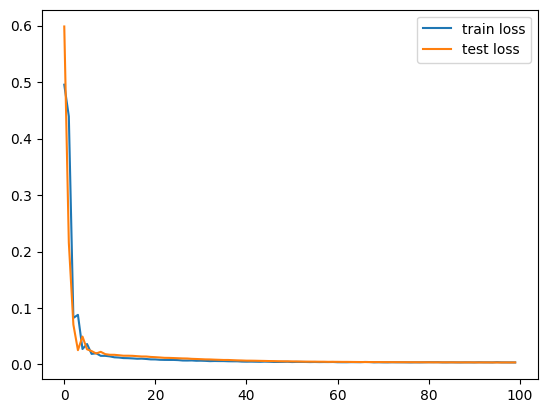

In [682]:
print(train_losses)
print(test_losses)
import matplotlib.pyplot as plt
# plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
# save the figure to figures folder
plt.savefig('figures/loss.png')
plt.show()


In [683]:
from sklearn.metrics import accuracy_score

# Assuming model, X_train, X_test, y_train, y_test are already defined
# and 'device' is your CUDA device (like torch.device("cuda:0"))

with torch.no_grad():
    # Move X_train and X_test to the device
    X_train = X_train.to(device)
    X_test = X_test.to(device)

    # Get predictions
    p_train = model(X_train)
    p_test = model(X_test)

    # Move predictions back to CPU and convert to NumPy arrays
    p_train = p_train.cpu().numpy() * 100000
    p_test = p_test.cpu().numpy() * 100000
    
    # save the predictions and actual values to csv
    np.savetxt('data/predictions.csv', p_test, delimiter=',')
    np.savetxt('data/actual.csv', y_test, delimiter=',')

# Print predictions and actual values
print('Predict is', p_test)
print('The real is', y_test)

Predict is [[75478.52993011]
 [73580.22928238]
 [74211.5020752 ]
 [75825.08325577]
 [74640.42901993]
 [71448.65989685]
 [76619.66085434]
 [71408.59365463]
 [75696.96903229]
 [73185.88495255]
 [74619.65084076]
 [76756.63232803]
 [75554.37088013]
 [72699.48720932]
 [74835.09778976]
 [73650.08592606]
 [78037.64343262]
 [74356.59170151]
 [74331.98690414]
 [76185.46485901]
 [73596.13180161]
 [78909.85012054]
 [73503.88765335]
 [72301.39970779]
 [77062.74986267]
 [72590.78025818]
 [75134.64689255]
 [77873.36111069]
 [75606.65607452]
 [73932.46889114]
 [74084.46073532]
 [74849.04527664]
 [73564.18371201]
 [74391.93725586]
 [73421.01335526]
 [76569.16379929]
 [78914.91651535]
 [78427.74391174]
 [76748.51417542]
 [76519.41776276]
 [73499.34577942]
 [72091.00723267]
 [75408.67328644]
 [76549.17240143]
 [75804.98456955]
 [80597.09072113]
 [75035.08329391]
 [73524.5347023 ]
 [77072.69191742]
 [73161.79275513]
 [73746.31166458]
 [73320.29342651]
 [75459.90943909]
 [73292.14811325]
 [72170.94898224]

In [684]:
# save the train and test loss to csv
np.savetxt('data/train_losses.csv', train_losses, delimiter=',')
np.savetxt('data/test_losses.csv', test_losses, delimiter=',')

In [685]:
# save the model to checkpoint folder
torch.save(model.state_dict(), 'checkpoint/model1.pth')